# Analytics

## Imports and connection with database.

In [ ]:
import pandas as pd
import sqlite3
from pathlib import Path
import matplotlib.pyplot as plt

DB_PATH = Path("../data/olist.db")
conn = sqlite3.connect(DB_PATH)

df = pd.read_sql_query(
    "SELECT * FROM analytics_orders;",
    conn
)

#df.head()

,order_id,customer_id,customer_state,date,total_paid,order_revenue,delivery_days,year_month,day_of_week,purchase_hour
0,00010242fe8c5a6d1ba2dd792cb16214,3ce436f183e68e07877b285a838db11a,RJ,2017-09-13 08:59:02,72.19,72.19,7.0,2017-09,3,08
1,00018f77f2f0320c557190d7a144bdd3,f6dd3ec061db4e3987629fe6b26e5cce,SP,2017-04-26 10:53:06,259.83,259.83,16.0,2017-04,3,10
2,000229ec398224ef6ca0657da4fc703e,6489ae5e4333f3693df5ad4372dab6d3,MG,2018-01-14 14:33:31,216.87,216.87,7.0,2018-01,0,14
3,00024acbcdf0a6daa1e931b038114c75,d4eb9395c8c0431ee92fce09860c5a06,SP,2018-08-08 10:00:35,25.78,25.78,6.0,2018-08,3,10
4,00042b26cf59d7ce69dfabb4e55b4fd9,58dbd0b2d70206bf40e62cd34e84d795,SP,2017-02-04 13:57:51,218.04,218.04,25.0,2017-02,6,13


## Sanity Check

In [12]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96477 entries, 0 to 96476
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   order_id        96477 non-null  object 
 1   customer_id     96477 non-null  object 
 2   customer_state  96477 non-null  object 
 3   date            96477 non-null  object 
 4   total_paid      96477 non-null  float64
 5   order_revenue   96477 non-null  float64
 6   delivery_days   96469 non-null  float64
 7   year_month      96477 non-null  object 
 8   day_of_week     96477 non-null  object 
 9   purchase_hour   96477 non-null  object 
dtypes: float64(3), object(7)
memory usage: 7.4+ MB


,total_paid,order_revenue,delivery_days
count,96477.000000,96477.000000,96469.000000
mean,159.856357,159.827008,12.093170
std,218.813144,218.795346,9.550476
min,9.590000,9.590000,0.000000
25%,61.880000,61.850000,6.000000
50%,105.280000,105.280000,10.000000
75%,176.330000,176.260000,15.000000
max,13664.080000,13664.080000,209.000000


De acuerdo al análisis realizado en `01_eda.ipynb` no se perdieron filas.

In [ ]:
df["purchase_hour"].describe()


count     96477
unique       24
top          16
freq       6476
Name: purchase_hour, dtype: object

In [25]:
df["purchase_hour"].value_counts().sort_index()

purchase_hour
00    2321
01    1133
02     496
03     259
04     203
05     182
06     478
07    1199
08    2907
09    4647
10    5978
11    6385
12    5802
13    6309
14    6383
15    6249
16    6476
17    5963
18    5585
19    5801
20    6007
21    6040
22    5659
23    4015
Name: count, dtype: int64

No se observan problemas en este campo.

## Segmentación por gasto

Vamos a dividir las ordenes en tres grupos según su gasto.

In [13]:
df["spend_segment"] = pd.qcut(
    df["total_paid"],
    q=3,
    labels=["low", "medium", "high"]
)

* Revenue por grupo:

C:\Users\Sebastian\AppData\Local\Temp\ipykernel_2584\4076365970.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  seg = df.groupby("spend_segment")["total_paid"].sum() / df["total_paid"].sum()


<Axes: title={'center': 'Revenue por segmento de gasto'}, xlabel='spend_segment'>

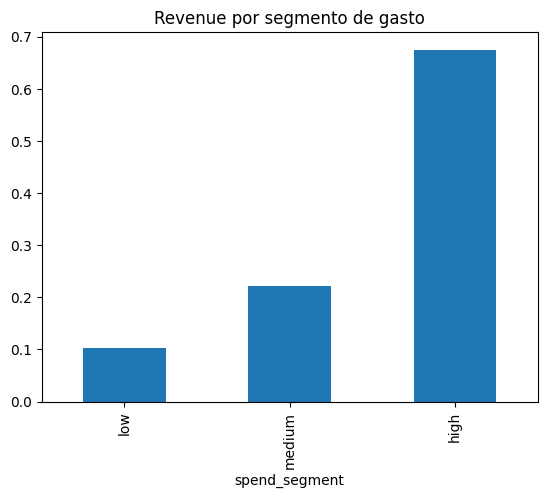

In [14]:
seg = df.groupby("spend_segment")["total_paid"].sum() / df["total_paid"].sum()

seg.plot(kind="bar", title="Revenue por segmento de gasto")


* Cantidad de ordenes por grupo:

<Axes: title={'center': 'Proporción de órdenes por segmento'}, xlabel='spend_segment'>

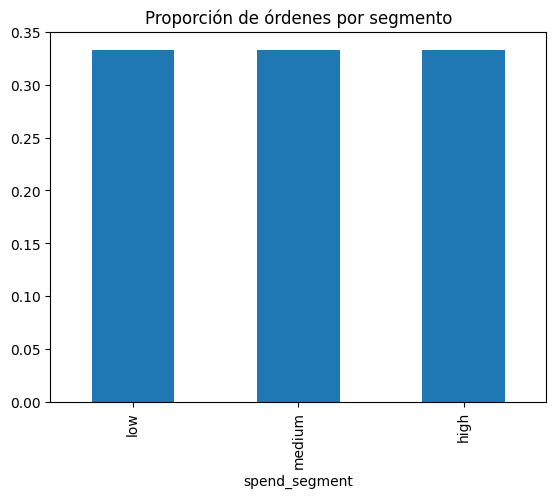

In [15]:
orders_pct = df["spend_segment"].value_counts(normalize=True).sort_index()

orders_pct.plot(kind="bar", title="Proporción de órdenes por segmento")

Como usamos qcut, los tres grupos tienen la misma cantidad de ordenes.

* Ticket promedio por grupo

C:\Users\Sebastian\AppData\Local\Temp\ipykernel_2584\3911666881.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_ticket = df.groupby("spend_segment")["total_paid"].mean()


<Axes: title={'center': 'Ticket promedio por segmento'}, xlabel='spend_segment'>

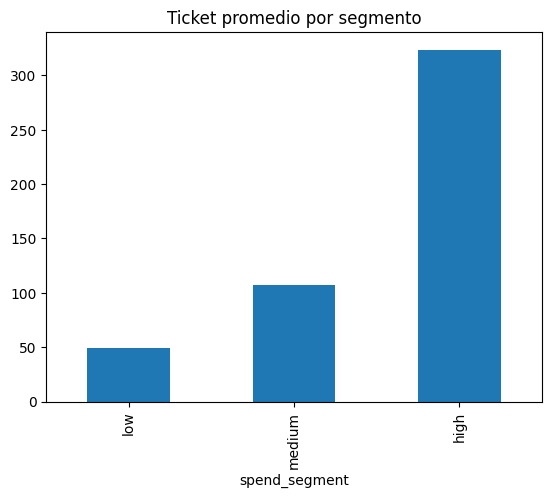

In [16]:
avg_ticket = df.groupby("spend_segment")["total_paid"].mean()

avg_ticket.plot(kind="bar", title="Ticket promedio por segmento")

**Conclusiones:**

* Aunque los segmentos tienen volúmenes similares de órdenes, el segmento de alto gasto concentra una proporción significativamente mayor del revenue total.

* El ticket promedio aumenta de forma escalonada entre segmentos, evidenciando una fuerte heterogeneidad en el valor económico de las órdenes.

* Esto sugiere que estrategias focalizadas en clientes de alto gasto podrían tener un impacto desproporcionadamente alto sobre el revenue total.

## Logística vs Gasto

Analizaremos si hay relación entre cuanto gasta un cliente y que tan rápido recibe su pedido.

* Tiempo promedio de entrega por segmento de gasto.

C:\Users\Sebastian\AppData\Local\Temp\ipykernel_2584\428494933.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  delivery_by_segment = df.groupby("spend_segment")["delivery_days"].mean()


<Axes: title={'center': 'Tiempo promedio de entrega por segmento de gasto'}, xlabel='spend_segment'>

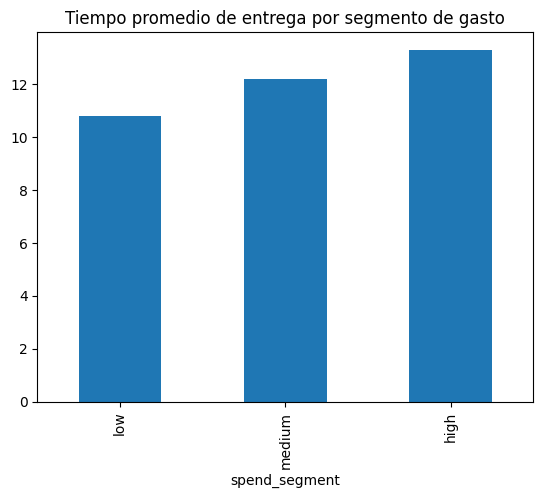

In [17]:
delivery_by_segment = df.groupby("spend_segment")["delivery_days"].mean()

delivery_by_segment.plot(
    kind="bar",
    title="Tiempo promedio de entrega por segmento de gasto"
)

* Mediana por cada segmento:

C:\Users\Sebastian\AppData\Local\Temp\ipykernel_2584\2196492857.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("spend_segment")["delivery_days"].median().plot(kind="bar", title= "Mediana de días de entrega por segmento de gasto")


<Axes: title={'center': 'Mediana de días de entrega por segmento de gasto'}, xlabel='spend_segment'>

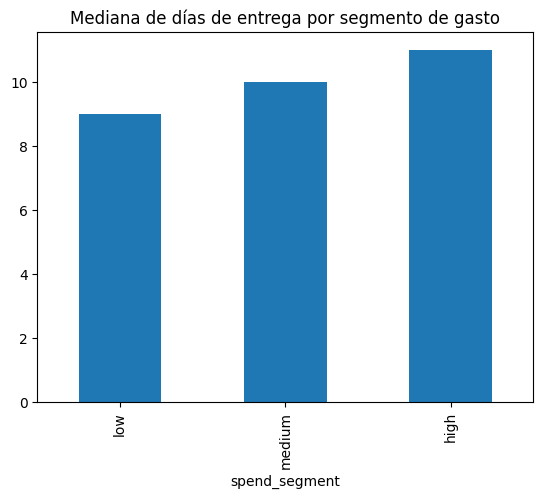

In [21]:
df.groupby("spend_segment")["delivery_days"].median().plot(kind="bar", title= "Mediana de días de entrega por segmento de gasto")

* Dispersión por cada segmento

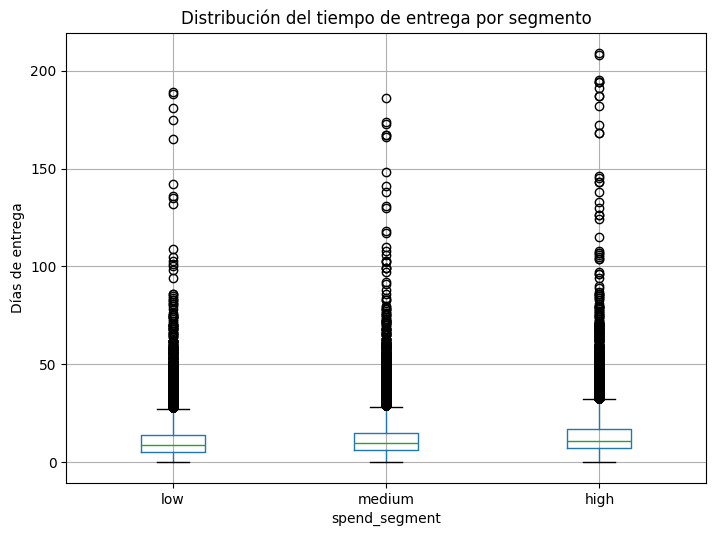

In [18]:
df.boxplot(
    column="delivery_days",
    by="spend_segment",
    figsize=(8,6)
)

plt.title("Distribución del tiempo de entrega por segmento")
plt.suptitle("")
plt.ylabel("Días de entrega")
plt.show()

In [19]:
df.groupby("spend_segment")["delivery_days"].agg(["mean","median","std","count"])

C:\Users\Sebastian\AppData\Local\Temp\ipykernel_2584\114225161.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("spend_segment")["delivery_days"].agg(["mean","median","std","count"])


,mean,median,std,count
spend_segment,,,,
low,10.798290,9.0,8.702005,32165
medium,12.192119,10.0,9.345847,32152
high,13.289624,11.0,10.366205,32152


**Conclusiones:**

El análisis muestra un incremento progresivo en los tiempos de entrega promedio y medianos a medida que aumenta el valor de la orden. Además, se observa una mayor variabilidad en los tiempos de entrega dentro del segmento de alto gasto. Esto podría estar relacionado con diferencias en la complejidad logística, características de los productos o distancias de envío. La presencia de numerosos outliers es consistente con la naturaleza de los procesos logísticos reales, donde pueden existir demoras excepcionales.

## Comportamiento horario

* Cantidad de ordenes por hora:

Text(0.5, 1.0, 'Ordenes por hora')

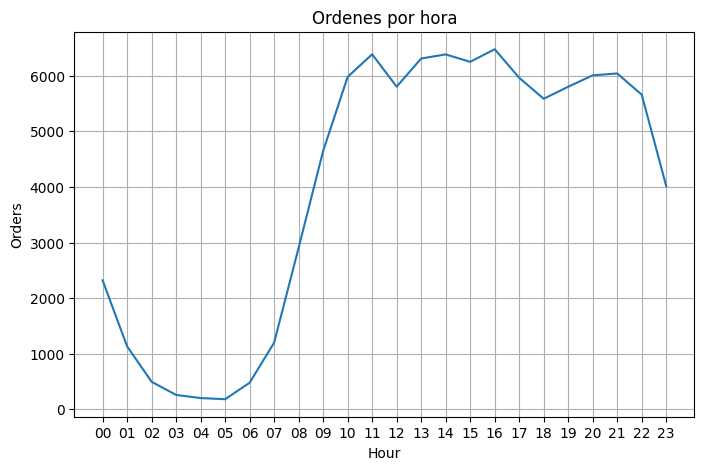

In [50]:
orders_by_hour = df.groupby("purchase_hour")["order_id"].count()


plt.figure(figsize=(8,5))

plt.plot(orders_by_hour)
plt.xlabel("Hour")
plt.ylabel("Orders")
plt.grid()
plt.title("Ordenes por hora")


* Ticket promedio por hora:

Text(0.5, 1.0, 'Average ticket per hour')

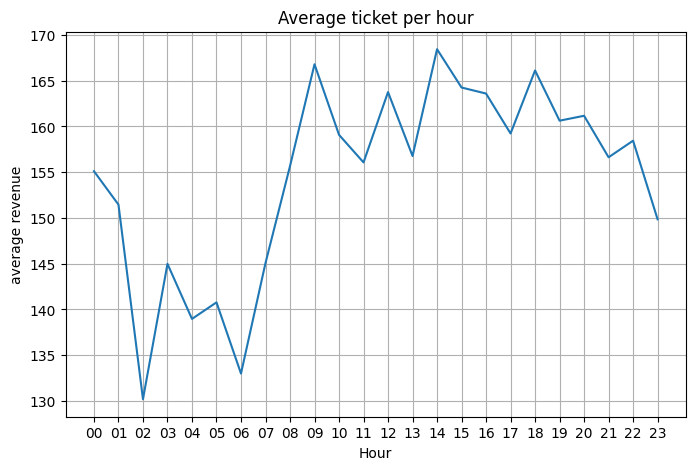

In [51]:
avg_ticket_hour = df.groupby("purchase_hour")["total_paid"].mean()


plt.figure(figsize=(8,5))

plt.plot(avg_ticket_hour)
plt.xlabel("Hour")
plt.ylabel("average revenue")
plt.grid()
plt.title("Average ticket per hour")


* Revenue total por hora

Text(0.5, 1.0, 'Revenue by hour')

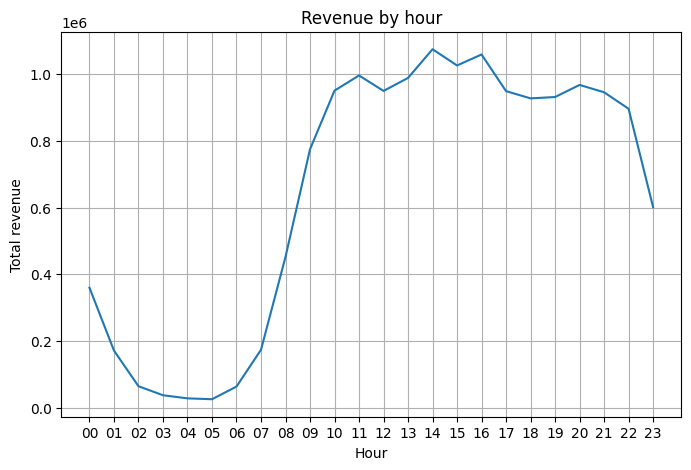

In [52]:
revenue_by_hour = df.groupby("purchase_hour")["total_paid"].sum()

plt.figure(figsize=(8,5))

plt.plot(revenue_by_hour)
plt.xlabel("Hour")
plt.ylabel("Total revenue")
plt.grid()
plt.title("Revenue by hour")

* Matriz hora vs día de semana

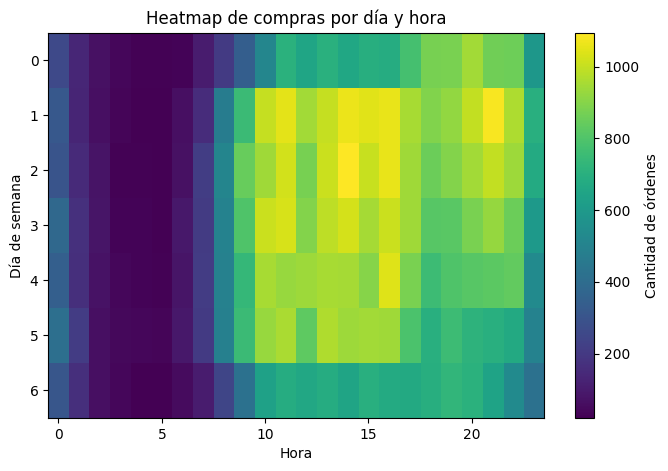

In [53]:
pivot = df.pivot_table(
    values="order_id",
    index="day_of_week",
    columns="purchase_hour",
    aggfunc="count"
)

plt.figure(figsize=(8,5))
plt.imshow(pivot, aspect="auto")
plt.colorbar(label="Cantidad de órdenes")

plt.title("Heatmap de compras por día y hora")
plt.xlabel("Hora")
plt.ylabel("Día de semana")

plt.show()

In [54]:
pivot

purchase_hour,00,01,02,03,04,05,06,07,08,09,...,14,15,16,17,18,19,20,21,22,23
day_of_week,,,,,,,,,,,,,,,,,,,,,
0,256,137,68,41,27,26,30,102,202,341,...,660,696,688,777,875,881,944,863,858,591
1,315,132,63,34,21,22,64,157,471,752,...,1063,1047,1060,954,891,920,998,1083,962,697
2,300,151,79,28,28,24,69,216,510,845,...,1095,1005,1059,943,852,894,946,996,939,676
3,385,171,81,31,33,24,91,208,497,798,...,1027,952,1008,943,818,822,881,927,855,600
4,345,165,74,38,30,28,82,211,495,736,...,951,901,1042,881,759,798,816,826,835,533
5,412,210,66,46,39,35,91,203,487,754,...,937,948,943,791,697,757,714,700,675,496
6,308,167,65,41,25,23,51,102,245,421,...,650,700,676,674,693,729,708,645,535,422


**Conclusiones:**

Se observa que el mayor volumen de órdenes se concentra entre las 10 y las 21 horas, con picos alrededor del mediodía. En estos mismos rangos horarios también se registran los valores más altos tanto en ticket promedio como en revenue total, lo que sugiere que los mayores ingresos están asociados a los horarios de mayor actividad y no a franjas horarias atípicas.

Por otro lado, el mapa de calor muestra que la mayor cantidad de compras se realiza durante los días de semana, especialmente en la primera mitad de la semana, donde se concentran los niveles más altos de actividad.

## Performance vs Estado

* Métricas base por estado:

In [56]:
state_perf = df.groupby("customer_state").agg(
    total_orders=("order_id", "count"),
    total_revenue=("total_paid", "sum"),
    avg_ticket=("total_paid", "mean"),
    avg_delivery_days=("delivery_days", "mean")
).sort_values("total_revenue", ascending=False)

state_perf.head()

,total_orders,total_revenue,avg_ticket,avg_delivery_days
customer_state,,,,
SP,40500,5770266.19,142.475708,8.296965
RJ,12350,2055690.45,166.452668,14.848583
MG,11354,1819277.61,160.232307,11.542188
RS,5345,861802.40,161.235248,14.819237
PR,4923,781919.55,158.829890,11.526711


* Revenue por estado (Top 10)

<Axes: title={'center': 'Top estados por revenue'}, xlabel='customer_state'>

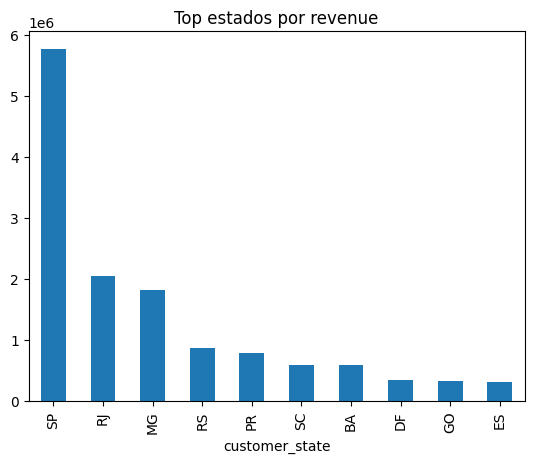

In [57]:
state_perf["total_revenue"].head(10).plot(kind="bar", title="Top estados por revenue")

* Ticket promedio por estado

<Axes: title={'center': 'Estados con mayor ticket promedio'}, xlabel='customer_state'>

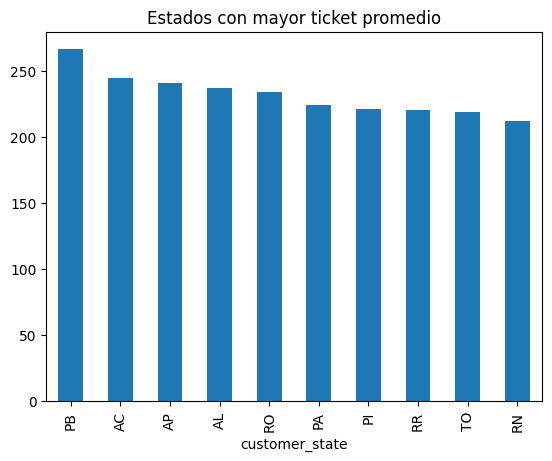

In [58]:
state_perf.sort_values("avg_ticket", ascending=False)["avg_ticket"].head(10)\
    .plot(kind="bar", title="Estados con mayor ticket promedio")


* Delivery vs Revenue

<Axes: title={'center': 'Delivery promedio vs Revenue por estado'}, xlabel='avg_delivery_days', ylabel='total_revenue'>

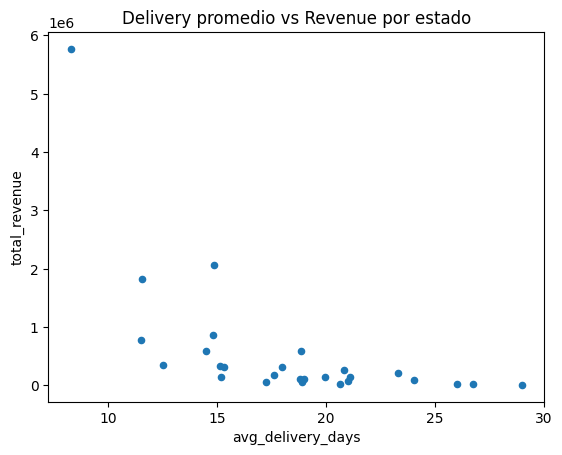

In [59]:
state_perf.plot.scatter(
    x="avg_delivery_days",
    y="total_revenue",
    title="Delivery promedio vs Revenue por estado"
)


**Conclusiones:**

El análisis geográfico muestra una fuerte concentración del revenue en ciertos estados, destacándose principalmente São Paulo como el principal generador de ingresos. Sin embargo, este liderazgo parece estar explicado principalmente por el volumen de órdenes y no necesariamente por un mayor gasto individual de los clientes.

De hecho, al observar el ticket promedio, se evidencia que los estados con mayor revenue total no coinciden con aquellos que presentan los mayores niveles de gasto por orden. Esto sugiere que existen dos dinámicas diferentes: estados con alta actividad comercial y volumen de compras, frente a estados con menor cantidad de órdenes pero tickets promedio más elevados.

Por otra parte, el análisis conjunto entre revenue y tiempo de entrega indica una relación negativa entre ambas variables, observándose que los estados con mayor volumen de ingresos tienden a presentar tiempos de entrega más bajos. Si bien esta relación no implica causalidad directa, puede estar asociada a factores estructurales como mayor infraestructura logística, mayor densidad poblacional o proximidad a centros de distribución.

En conjunto, estos resultados destacan la importancia de analizar simultáneamente volumen, comportamiento de gasto y variables operativas para comprender las diferencias regionales en el desempeño del negocio.